# 4. Dynamics (Solution)

In this Notebook we will introduce the __dynamic model__, also commonly referred as the __dynamics__. The dynamic model relates the forces/torques applied in the robot's actuators to the joint positions, velocities and accelerations. Similarily to the geometric and kinematic model, there are two kinds of dynamic models:

- __Direct Dynamic Model (DDM)__ : given joint forces and torques, it enables to calculate the resulting joint motion (positions $q$, velocities $\dot{q}=\frac{dq}{dt}$ and accelerations $\ddot{q}=\frac{d \dot{q}}{dt}$) 
- __Inverse Dynamic Model (IDM)__ : given a joint space motion, it enables to deduce the forces and torques applied in each joint

__Note__ : you may want to review [Newton's Laws of Motion](https://en.wikipedia.org/wiki/Newton%27s_laws_of_motion) and the notion of [torque](https://www.grc.nasa.gov/WWW/K-12/airplane/torque.html) before starting this Notebook

In [14]:
## This is the implementation of a 1 degree of freedom arm
## Author: Avadesh Meduri
## Date : 21/06/2020

import numpy as np
from matplotlib import pyplot as plt

# these packages for animating the robot env
import IPython
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation


In order to execute some desired motion, we need to tell each actuator which contribution it should bring to the general joint space motion. The commands ultimately sent to the robot's actuators are the typically motor currents (eletrical actuation) or pistons fluid pressure (hydraulic actuation). But on a higher level, what causes these motion are forces and torques output by the actuators, regardless of how they internally function. So for now, we will disgard the low-level actuation process and assume "ideal" actuators than generate directly a force or a torque when commanded so.   

Now let us take again the example of the 1R robot. 

__Important note: the angle convention used in the following (i.e. $q$ measured w.r.t. $y$-axis) is different than the one we used in the previous notebooks on modeling (i.e. $q$ measured w.r.t. $x$-axis). The present convention is the most common for analyzing the simple pendulum system__

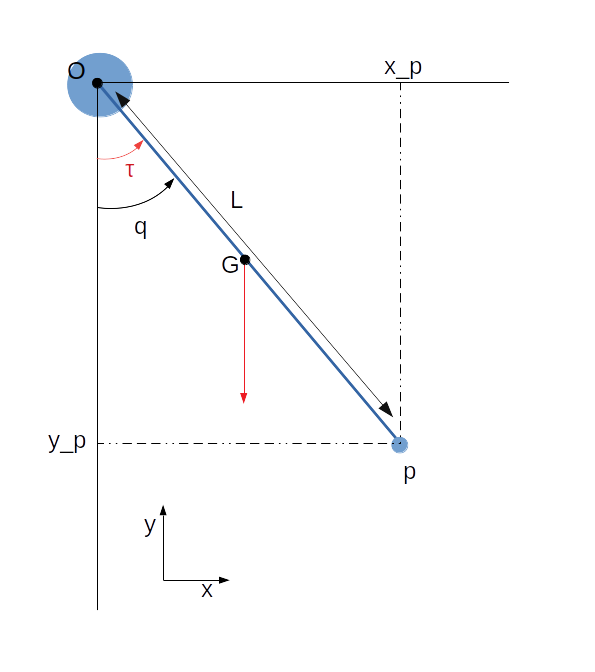

In [13]:
from IPython.display import Image

# Display the 1R robot
Image("1dof-dyn.png")

Neglecting the actuator's dynamics, the rotational joint in $O$ can be viewed as a pure torque source. This torque $\tau$, together with the effect of gravity, generates an angular acceleration $\ddot{q}$. These two quantities satisfy [Euler's law](https://en.wikipedia.org/wiki/Euler%27s_laws_of_motion) :

$$
\tau + \sum \vec{M}_O(\vec{F}) = I \ddot{q}
$$

where 
- $ \sum \vec{M}_O(\vec{F})$ represent the sum of the moments of external forces applied on the robot, taken with respect to the base / origin point $O$
- $I$ is the [inertia](https://en.wikipedia.org/wiki/List_of_moments_of_inertia) of the link (in $kg.m^2.s^2$)

Here the only external force applied on the robot is gravity, acting at the center of mass $G$ and given by $\vec{F}_{gravity} = -mg \vec{y}$ (red arrow in the picture). 

__Question__ : Assuming that $\|\vec{OG}\| = \frac{L}{2}$, what it the moment due to gravity about $O$ ? 

Hint: Use the definition of the [moment of a force about a point](https://www.miniphysics.com/moment-of-force.html)

__Answer__ : The moment of gravity about $O$ is by definition

$$
\vec{M}_O(\vec{F}_{gravity}) = \vec{OG} \times \vec{F}_{gravity} = -\frac{L}{2}mg\sin(q)
$$

__Question__ : Knowing the moment of gravity, how to deduce the DDM / IDM ?

__Answer__ : $\tau$ and $\ddot{q}$ are related as

$$
\tau -\frac{L}{2}mg\sin(q) = I \ddot{q}
$$

From this equation, it is easy to deduce the DDM and IDM. Given the joint space motion of the 1R robot, the IDM explains which torque is exerted on the joint 

$$
\tau = I \ddot{q} + \frac{L}{2}mg\sin(q)
$$

Conversely, inverting this model yields the DDM which predicts the joint space motion caused by a given torque

$$
\ddot{q} = \frac{\tau}{I} - \frac{L}{2I}mg\sin(q)
$$

__Question__ : The class below implements the DDM of the 1R robot. Complete the code. Use $I=\frac{1}{3}mL^2$

The differential equation describing the robot's dynamics derived from the laws of physics is a _continuous-time_ ODE (meaning that $t\in\mathbb{R}$). In order to be able to simulate the system in a program, we need to approximate it by a _discrete-time_ ODE (where $t=1,2,...$). This procedure is called _discretization_ and is crucial to understand how simulations work. Blabla + Euler

In [5]:
class OneDOFManipulator:
    
    def __init__(self, length, mass):
        '''
        This function initialises the class OneDOFManipulatorEnv
        Input:
            length : lenght of the arm
            mass : mass of the rod
        '''
        
        self.length = length
        self.dt = 0.001 # discretization step in seconds
        self.g = 9.81 # gravity vector
        self.m = mass
        # Computing the intertia of the rod about an axis
        # fixed at the end (1/3)ml^2
        self.I = (1/3)*self.m*(self.length**2)
        
    def dynamics(self, theta, theta_dot, torque):
        '''
        This function computes the dynamics (dy/dt = f(y,t)) of the manipulator given
        the current state of (Joint POsition, Joing Velocity)
        Input:
            theta : joint position 
            theta_dot : joint velocity
            torque : torque applied at the end of manipulator
        '''
        
        theta_rad = (np.pi/180)*theta # converting from degree to radians
        return theta_dot, (torque - self.m*self.g*np.sin(theta_rad))/self.I
    
    def integrate_dynamics_euler(self, theta_t, theta_dot_t, torque_t):
        '''
        This function integrates the dynamics of the manipulator for one time step (0.001 sec)
        Input:
            theta_t : joint position at current time
            theta_dot_t : joint velocity at current time
            torque_t : torque applied at the end of manipulator at current time
        '''
        
        joint_velocity, joint_acceleration = self.dynamics(theta_t, theta_dot_t, torque_t)
        
        # integrating using euler integration scheme
        # refer to this link for more details : https://en.wikipedia.org/wiki/Euler_method
        
        theta_t_1 = theta_t + joint_velocity*self.dt
        theta_dot_t_1 = theta_dot_t + joint_acceleration*self.dt
        
        return theta_t_1, theta_dot_t_1
    
    def integrate_dynamics_runga_kutta(self, theta_t, theta_dot_t, torque_t):
        '''
        This function integrates the dynamics of the manipulator for one time step (0.001 sec)
        using runga kutta integration scheme
        Input:
            theta_t : joint position at current time
            theta_dot_t : joint velocity at current time
            torque_t : torque applied at the end of manipulator at current time
        '''
        
        # Runga Kutta is more stable integration scheme as compared to euler
        # refer to this link for more details of runga kutta integration scheme : 
        # https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods
        
        k1_thd, k1_thdd  = self.dynamics(theta_t, theta_dot_t, torque_t)
        k2_thd, k2_thdd  = self.dynamics(theta_t + 0.5*self.dt*k1_thd, theta_dot_t + 0.5*self.dt*k1_thdd, torque_t)
        k3_thd, k3_thdd  = self.dynamics(theta_t + 0.5*self.dt*k2_thd, theta_dot_t + 0.5*self.dt*k2_thdd, torque_t)
        k4_thd, k4_thdd  = self.dynamics(theta_t + self.dt*k3_thd, theta_dot_t + self.dt*k3_thdd, torque_t)
        
        theta_t_1 = theta_t + (1/6)*self.dt*(k1_thd + 2*k2_thd + 2*k3_thd + k4_thd)
        theta_dot_t_1 = theta_dot_t + (1/6)*self.dt*(k1_thdd + 2*k2_thdd + 2*k3_thdd + k4_thdd)
        
        return theta_t_1, theta_dot_t_1 
        
    def reset_manipulator(self, initial_theta, initial_theta_dot):
        '''
        This function resets the manipulator to the initial position
        Input:
            initial_theta : starting joint position
            initial_theta_dot : starting joint velocity
        '''
        # creating an array sim_data (simulate data) that stores the joint positions,
        # joint velocities and torques at each time step. Each column corresponds to a the 
        # time step. Row 1 contains joint position, Row 2 contains joint velocity, Row 3 contains
        # torque provided by user at the given time step.
        
        self.sim_data = np.array([[initial_theta], [initial_theta_dot], [0.0]])
        self.t = 0 # time counter in milli seconds
            
    def step_manipulator(self, torque, use_euler = True):
        '''
        This function integrates the manipulator dynamics for one time step
        Input:
            torque : Input torque at the given time step
        '''
        # storing torque provided by user
        self.sim_data[:,self.t][2] = torque
        
        if use_euler:
            
            theta_t = self.sim_data[:,self.t][0]
            theta_dot_t = self.sim_data[:,self.t][1]
            
            theta_t_1, theta_dot_t_1 = self.integrate_dynamics_euler(theta_t, theta_dot_t, torque)
        
        else:
            theta_t = self.sim_data[:,self.t][0]
            theta_dot_t = self.sim_data[:,self.t][1]
            
            theta_t_1, theta_dot_t_1 = self.integrate_dynamics_runga_kutta(theta_t, theta_dot_t, torque)
            
        # keeping theta between (0, 360)
        if theta_t_1 > 360:
            theta_t_1 = theta_t_1%360
        
        # transforming new joint positions and velocity into array form
        sim_data_t_1 = np.array([[theta_t_1], [theta_dot_t_1], [0.0]])
        # adding the data to sim_data
        self.sim_data = np.concatenate((self.sim_data, sim_data_t_1), axis = 1)
        # incrementing time
        self.t += 1
        
    def get_joint_position(self):
        '''
        This function returns the current joint position (degrees) of the mainpulator
        '''
        return self.sim_data[:,self.t][0]
    
    def get_joint_velocity(self):
        '''
        This function returns the current joint velocity (degrees/sec) of the mainpulator
        '''
        return self.sim_data[:,self.t][1]
    
    def animate(self, freq = 100):
        
        sim_data = self.sim_data[:,::freq]

        fig = plt.figure()
        ax = plt.axes(xlim=(-self.length -1, self.length + 1), ylim=(-self.length -1, self.length + 1))
        text_str = "One Dof Manipulator Animation"
        arm, = ax.plot([], [], lw=4)
        base, = ax.plot([], [], 'o', color='black')
        hand, = ax.plot([], [], 'o', color='pink')
        
        def init():
            arm.set_data([], [])
            base.set_data([], [])
            hand.set_data([], [])
            
            return arm, base, hand
        
        def animate(i):
            theta_t = (np.pi/180)*sim_data[:,i][0]
            
            x = self.length*np.sin(theta_t)
            y = -self.length*np.cos(theta_t)
            
            arm.set_data([0,x], [0,y])
            base.set_data([0, 0])
            hand.set_data([x, y])

            return arm, base, hand
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
        ax.grid()
        anim = FuncAnimation(fig, animate, init_func=init,
                                       frames=np.shape(sim_data)[1], interval=25, blit=True)

        plt.close(fig)
        plt.close(anim._fig)
        IPython.display.display_html(IPython.core.display.HTML(anim.to_html5_video()))

    def plot(self):
        '''
        This function plots the joint positions, velocities and torques
        '''
        
        fig, axs = plt.subplots(3,1, figsize = (10, 10))
        axs[0].plot(self.sim_data[0], label = 'joint position')
        axs[0].grid()
        axs[0].legend()
        axs[0].set_ylabel("degrees")

        axs[1].plot(self.sim_data[1], label = 'joint velocity')
        axs[1].grid()
        axs[1].legend()
        axs[1].set_ylabel("degrees/sec")
    
        axs[2].plot(self.sim_data[2,:-1], label = 'torque')
        axs[2].grid()
        axs[2].legend()
        axs[2].set_ylabel("Newton/(Meter Second)")
    
    
        plt.show()

Now the code is tested 

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABt0m1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABZIZYiE
AC///vau/MsrRwuVLh1Ze7NR8uhJcv2IMH1oAAADAADVayF8oYJVUBjgvNA9NyX0pOD8+0aEKaS/
W+kRxFrWNzf+eSO4TQp9X9rSQjTItyhp18FcAAFYwPSb9MNj7345mZM2SCpqc/4dq8TkXuq00M8Q
OvVEaAcaB8dFKy0nxv6lS/KsJVTGkw7kt4VpUBgOXNkT5vbbHpQLGFTaisacVyNWLNCImxrwyoEY
lJx5jyLlf5PD8ImwFKMLmZhi2TEEJtj3Qj8XsVBnTDa0n2NZNmKYwiD2HQCWX3YGsH3eAXRAw0GN
nPrJChu2Oj+fWM9vfc8for3GgMKCwyrXCcmp8xg3z6QesW5DsIuqIcXZi7gu6wRqcCurfjL12aIG
PRiqBVzXTP8EYpSD58LhroiDE2VfcEXE3kA+cpjYUt2soByw9elbd8doo9R3VOK65MJEEXes7KUJ
bkx3etzG40cyGhwQcKMM8CjudqpamGhDH8xBhmcZXQTpTElOHD8GBc5rrlE6r8T9g33DiFZbxagQ
FWGwgLuQSuA8T62So5G3x3UUsAahpLMguVZjpoAXFB2ccc8oRADM2/zIjjjNGGS4zybFOyrYuOqk
ibvHRiuXQLsfkm7mGPFaawqH6OZYfwe5LVJbPxBUuW+GlTVxNNO1hTdNHh5wHyNFRuto8SkzP7GY
0NCWNSTi7ggJKf9ezQlLXUz1H02UY1ajxcKA+HsR3hzGUi2YdqJCda9MK85SP9Pp7ZCNwCIhEU2j
NM6XZIH+jmQRZji/+FbT3rXSIHs9iEuSerzcZF/aLRtODmUAkIRsIon5IwLDpyL9+7iJr7SKy+rI
rTp6zpg79QIjQEU/sdBJHGldKjvsArYfTuujdkNcgzCMcyhVwnQGYuaBn8ir7/6MEV/38DqKgowW
E+qCKVwrfSLskHOCDx+xiSCHPJXWQwEpOIIQaY//bwHxqjlaRNTbNR0meuVhVwqtm+RwOqqjSJlA
F05cCuxMYVgj4Gf/MRGgg413lbv7NIx3cFUMJCXFW0/lLzima7DjFwQEtFMfo9upVWxz0J7nHTdH
kXSTtkN4FwvA6yArsibqoC6ta1Z6uhXGqPWTNqwrUkQgBM2/MjFsdvl6Gv7b2WH4sUpp7ngJdo+M
YZL7u/Wxd4MC6M0votg/WuSYfW8O9eGwcJZVdWpxoS9QnnTY6tW6y0h/BfaGf3MDpZUm1O9f5esS
yjMeoy5CVxgMT2aArKoR0mUVpQVlfIM5DEu+CAQ0xrp3YgCL/HClsdVsfBszUBXEBZHlLO++KHZI
5Fz0KEE++tJdtLBOoNkIKzLLiVhFFRTtqeQDJYjde9BzrBjAn7ZK035NbODW50QwPansuyxlEYRO
uJp8yaut9jMAK81kGFtNZaxlJxWIMAJ6X72vWspxC0Y2N7wlzNF2PEa1eV7mJM3RK/dhpld+K9UQ
eP/Ab6pd9CZ94fVpAXboyw3neQhbrt/T27TBPe9trYhwYXHFyww3NpwC7rhKQ5t7uqtzI/4bdtho
0E11YHJNHB0fA8lAIZ/PlZ0owBwPtohLK6yDbI7fqtmiFMb/cDRnWx0VoSOGtfJwDnof841cD4qH
iDq9qo6jnuYJXw6mLYMxNBM8TqETaD1eW4k+NjjfE+8DMsCY2SjqlYW6aNk8E/Ao3Votv6GfpJt1
tzNMK/dp7Ai0WXekW4Xol6wEUJ0HlaT0Q6WeD58IOzTzMa78vkDhI4LSHOPQVGAkWPcjT1bPHmUt
XOY91seiCvf/XP02UuJqe/wq24KEoNBGNfXESHfUlY3kvw/0Vf70jmRBZNtogKJI+pYiAUDu+W6I
NQvUbbHUWN3XT4g7VP0CHNcxoo3cL3XBshiW+o/ZjMwLYf4L0Ct7hC4bOJ1Zay3mHyzQ4mtQAqzu
ekPgnr4iJI4QzgQVv26oWdMECjNSDrREj66I3UU1qRRfY60N9BcPuntBT+DakKwwkHD1vKHqvdti
jf4LbGFsG9C8LWPLFXEk1/4dkW7UC5B3/Gi2ECbZDRhemU/ABBTp++i3hCQYi18zljOBSc9p+t14
9TNOoUEmOarhqUJapvhrIF3jM7HdR8Q9yHWfBRTx9iCxehaGb+hA0Bt0PLHTjDsci5ajB0B/asnC
71Uhr2RLh35gHla24wT8jlsVfT4TbYR0hkx/wawzsrt6QNM/miqPDeJ2jUPadlu2rr9l11skwXGG
SP+m9id0f/fWImKqWNUwroLKcaczHNpqNyn13hWVOYDI6VhdIEiWS2GiJpd+66L3V4Qbgtdn4D7O
S6Nszh9ZHKeo3mVkoLHwop0QlGFnGvoGjIr7HLxLas/l5uPjsNGSN/uJd1YN9jqdmKhiZGWnB5IV
p7FLjw6O4B605U1fFDPNXkFJ6ivWmpCVrXbDqwlFxicEt9v9n7mIRu/gBeZXG98ILluMdbImdeKT
v/1F5vN/YLjIJmcZbGNrfcfemU/qGdf1GAzBmALzjErj6cYGoehlD7neTiDrSANesZWwtNmGXgk4
fWTpLNZD3VEAJ99DcnJBssBFG61TeY+nHL22kGrWgQczWOU1K+5ZvFusQEsqKsQVctyD7ASrjGvD
GBwU+sm+gx7eR31bKI2NMSY7DKi5XhHtPqnoxe/TYrjDJ1bQk5TxLIWHDfB7MITREgE0lYNsU+/+
rxpXVcruW2U4W9p+giTbMypw5+MML30fTX4UkQXwE1Yoe7ZLRKmHo9rC0YbomuyFKI6fjkuEn8sv
XstLJ2xcj7N8Rvz9/XNuMY3E0+YPyyONSTyudTw453S9AOOWCnroPTjEoCFQq47e6wTqF/CnO//u
ummmF0Z7XR0uuplilLTvRDPylMuqjZht9vWWZIVIq+RLJRYGTCOgrY8+A0yYE93kihEHYTjuGQiU
LzCtijbO+dRJeoG8M7v+B

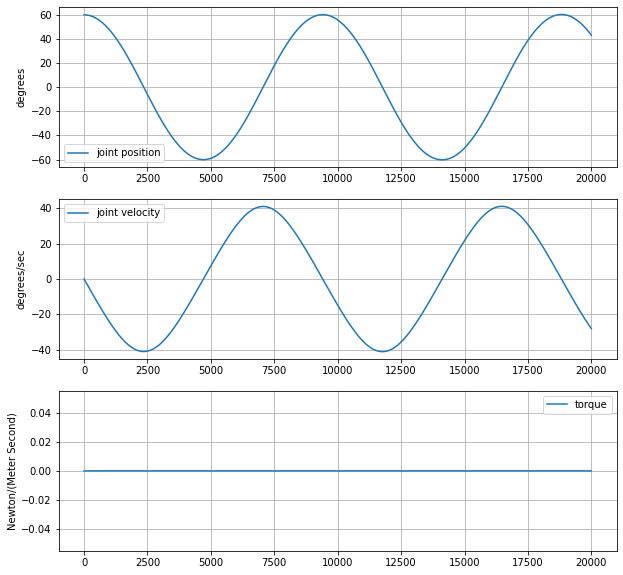

In [10]:
env = OneDOFManipulator(1, 1)
env.reset_manipulator(60,0)
horizon = 20000 # duration of simulation steps

for t in range(horizon):
    torque = 0.
    env.step_manipulator(torque, True)

env.animate()
env.plot()

Now the torque sent to the 1R robot doesn't seem to achieve anything special. What if we want to generate, say, a circle trajectory as we did using the kinematic planner ? Which torque to input ? That's the purpose of the IDM, also referred as __inverse dynamics__. Given a desired motion $q,\dot{q},\ddot{q}$ it returns the torque $\tau$ that must be applied. It corresponds to the equation :

__Question__ : In the environment class, implement an inverse dynamics member function called `inverse_dynamics`

__Question__ : Use the IDM function you implemented, and the simulation environment : 
- Calculate the sequence of torques to achieve a circle with the end-effector (Hint: first, use the `KinematicPlanner` from the previous Notebook to determine the desired $q,\dot{q}$).
- Simulate the sequence of torque, plot it as well as all relevant trajectories (end-effector, joints)

### Possible questions

1. Implement dynamics after reading theory in dynamics method of class
2. implement euler integration scheme (maybe runga kutta also)